In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from data_processing import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from data_transformar import *
import lightgbm as lgb
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor, Pool

warnings.simplefilter("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set(style="darkgrid")

In [2]:
from sklearn.metrics import mean_squared_error

cheat = pd.read_csv("./result-with-best.csv")

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cheat_score(model, val):
    print("RMSLE sub: " + str(rmsle(model.predict(val), np.log1p(cheat["SalePrice"]))))

def to_categorical(X):
    for c in X.columns:
        col_type = X[c].dtype
        if col_type == 'object' or col_type.name == 'category':
            X[c] = X[c].astype('category')

def evaluate(model, X, y):
    preds = model.predict(X)
    print("RMSLE: " + str(rmsle(preds, y)))

In [3]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=98987)
X_train_orig = X_train.copy()

transformer = DataTransformer(StandardScaler())

X_train = transformer.prepare(X_train)
X_test = transformer.prepare(X_test)

transformer.fit(X_train)

X_train = transformer.transform(X_train, False)
X_test = transformer.transform(X_test, False)

Int64Index([523, 1298], dtype='int64')


In [5]:
cat_features = np.where(X_train.loc[:, X_train.columns.values].dtypes == "object")[0]
#X_train.iloc[:, cat_features]

In [6]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
dev_pool = Pool(X_test, y_test, cat_features=cat_features)

cat_model = CatBoostRegressor(task_type="GPU",  devices='0:1')
cat_model.fit(train_pool, eval_set=dev_pool, verbose=0, plot=False, early_stopping_rounds=10)

evaluate(cat_model, X_train, y_train)
evaluate(cat_model, X_test, y_test)

RMSLE: 0.08877483035892854
RMSLE: 0.1228929009774494


In [7]:
cat_model.get_feature_importance(prettified = True)

,Feature Id,Importances
0,OverallQual,19.393214
1,TotalSF,19.084990
2,Total_sqr_footage,14.165015
3,YearBuilt,8.149040
4,OverallCond,5.744949
...,...,...
75,MoSold,0.002581
76,Heating,0.000098
77,MSSubClass,0.000000
78,Street,0.000000


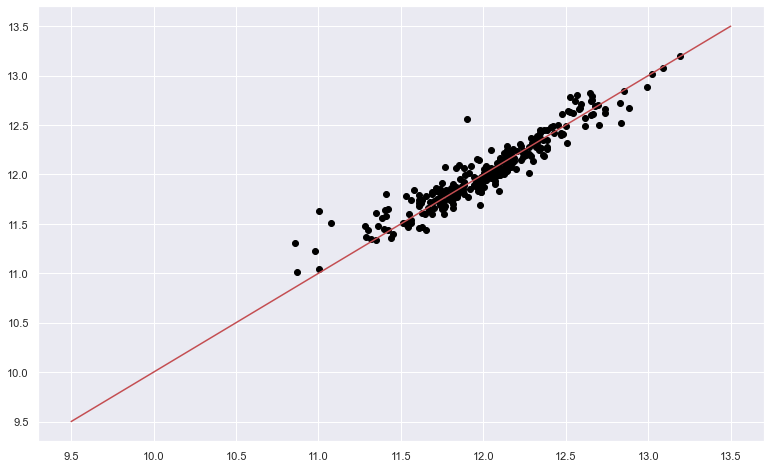

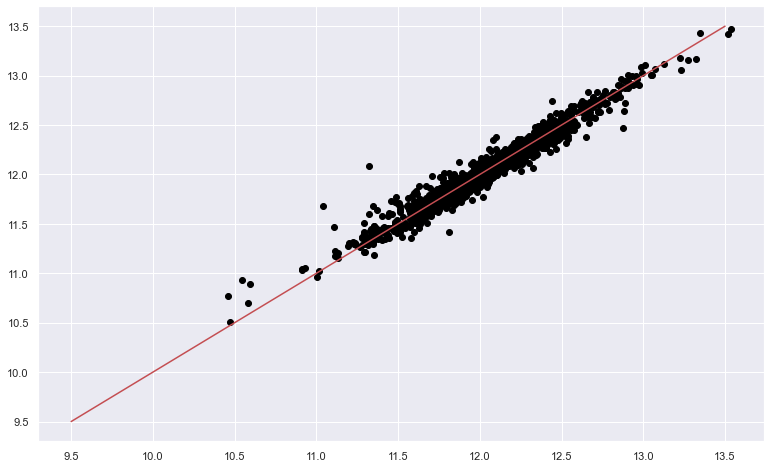

In [9]:
plt.figure(figsize=(13,8))
plt.scatter(y_test, cat_model.predict(X_test), color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')

plt.figure(figsize=(13,8))
plt.scatter(y_train, cat_model.predict(X_train), color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')

In [10]:
data = pd.read_csv("./train.csv")
data = data.drop(columns=["Id"])

#data = remove_outliers(data, True)

y = np.log1p(data["SalePrice"])
X = data.drop(columns=["SalePrice"])

transformer = DataTransformer(StandardScaler())
X = transformer.prepare(X)

transformer.fit(X)

X = transformer.transform(X, False)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

cat_features = np.where(X.loc[:, X.columns.values].dtypes == "object")[0]

In [11]:
validation = pd.read_csv("./test.csv")
val_ids = validation["Id"]
validation = validation.drop(columns=["Id"])

validation = transformer.prepare(validation)
validation = transformer.transform(validation, False)

In [15]:
train_pool = Pool(X, y, cat_features=cat_features)
dev_pool = Pool(X_val, y_val, cat_features=cat_features)

#400 - 0.12927241949496218
cat_model = CatBoostRegressor(iterations=200, task_type="GPU",  devices='0:1')
cat_model.fit(train_pool, verbose=0, plot=False)

evaluate(cat_model, X, y)

RMSLE: 0.07710493916833425


In [16]:
sub_predictions = cat_model.predict(validation)
print("RMSLE submission: " + str(rmsle(sub_predictions, np.log1p(cheat["SalePrice"]))))
#evaluate(lbg_model, validation,  np.log1p(cheat["SalePrice"]))

RMSLE submission: 0.12808560172392947


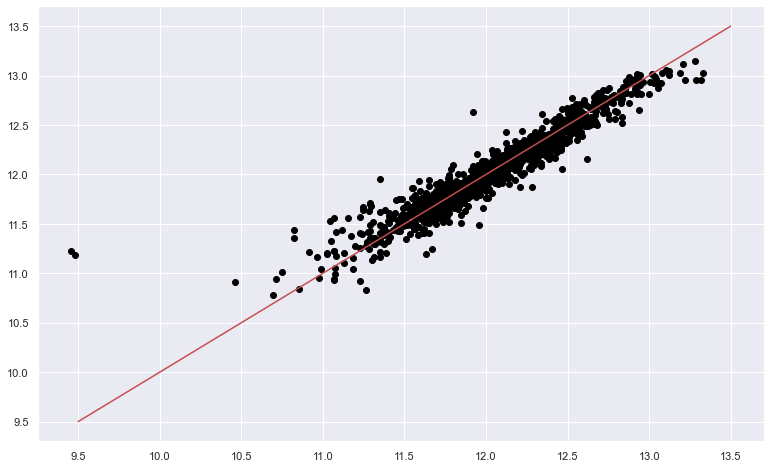

In [18]:
plt.figure(figsize=(13,8))
plt.scatter(np.log1p(cheat["SalePrice"]), sub_predictions, color='black')
plt.plot(np.linspace(9.5, 13.5, 2), np.linspace(9.5, 13.5, 2), c = 'r')